# Data Preparation
## Load multiple CSV files and combine them into a single DataFrame for further analysis

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Liste der CSV-Dateien
files = [
    "250502_flightradar_prepared.csv",
    "250501_flightradar_prepared.csv",
    "250430_flightradar_prepared.csv",
    "250429_flightradar_prepared.csv",
    "250428_flightradar_prepared.csv"
]

# Alle Dateien einlesen und in einem DataFrame zusammenführen
flightradar_all = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# Kontrolle
print(flightradar_all.head())
print("\n")
print(flightradar_all.dtypes)
print(flightradar_all.shape) 


  DESTINATION_CLEAN IATA_CODE     AIRLINE_CLEAN AIRCRAFT_SHORT  CANCELED  \
0           Antalya       AYT     Edelweiss Air           A359     False   
1          Pristina       PRN    Chair Airlines           A320     False   
2          Hurghada       HRG     Edelweiss Air           A320     False   
3            Bilbao       BIO     Edelweiss Air           A320     False   
4            Lisbon       LIS  TAP Air Portugal           A20N     False   

              DATETIME DEPART_TIME      DEPART_DATETIME  DELAY_MINUTES  
0  2025-05-02 05:45:00       06:07  2025-05-02 06:07:00             22  
1  2025-05-02 05:45:00       06:11  2025-05-02 06:11:00             26  
2  2025-05-02 06:00:00       06:13  2025-05-02 06:13:00             13  
3  2025-05-02 06:00:00       06:28  2025-05-02 06:28:00             28  
4  2025-05-02 06:10:00       06:41  2025-05-02 06:41:00             31  


DESTINATION_CLEAN    object
IATA_CODE            object
AIRLINE_CLEAN        object
AIRCRAFT_SHORT     

## Import weather dataset for analysis

In [71]:
# CSV‑Datei laden (im gleichen Verzeichnis wie dein Notebook)
weather = pd.read_csv("weather.csv")

# Erstmal Überblick verschaffen
print(weather.head())        # erste 5 Zeilen
print("\n")
print(weather.dtypes)        # Datentypen der Spalten
print(weather.shape)         # (Anzahl Zeilen, Anzahl Spalten)

                  time  temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  \
0  2025-04-28 00:00:00   9.9   8.3    90     0   NaN   293     2  15.0   
1  2025-04-28 01:00:00   8.4   8.0    97     0   NaN   276     5   9.0   
2  2025-04-28 02:00:00   8.2   7.8    97     0   NaN   283     7  13.0   
3  2025-04-28 03:00:00   7.8   7.0    95     0   NaN   304     3   7.0   
4  2025-04-28 04:00:00   5.8   5.5    98     0   NaN   306     4   6.0   

     pres  tsun  coco  
0  1024.8   NaN     2  
1  1025.0   NaN     2  
2  1024.8   NaN     2  
3  1024.7   NaN     5  
4  1025.1   NaN     5  


time     object
temp    float64
dwpt    float64
rhum      int64
prcp      int64
snow    float64
wdir      int64
wspd      int64
wpgt    float64
pres    float64
tsun    float64
coco      int64
dtype: object
(96, 12)


## Merge the two datasets: `flightradar_all` and `weather`


In [72]:
# Zeitspalten in datetime umwandeln
flightradar_all["DATETIME"] = pd.to_datetime(flightradar_all["DATETIME"])
weather["time"] = pd.to_datetime(weather["time"])

# Neue Spalte mit gerundeter Stunde erstellen
flightradar_all["DATETIME_HOUR"] = flightradar_all["DATETIME"].dt.floor("H")

# Sortieren (wichtig für merge_asof)
flightradar_all = flightradar_all.sort_values("DATETIME_HOUR")
weather = weather.sort_values("time")

# Nur relevante Wetterspalten auswählen
weather_subset = weather[["time", "temp", "snow", "coco"]]

# Merge durchführen
merged = pd.merge_asof(
    flightradar_all,
    weather_subset,
    left_on="DATETIME_HOUR",
    right_on="time",
    direction="nearest"
)

# Ergebnis prüfen
print(merged.head(10))


   DESTINATION_CLEAN IATA_CODE     AIRLINE_CLEAN AIRCRAFT_SHORT  CANCELED  \
0            Larnaca       LCA     Edelweiss Air           A320     False   
1           Pristina       PRN    Chair Airlines           A319     False   
2              Olbia       OLB     Edelweiss Air           A320     False   
3          Marrakesh       RAK     Edelweiss Air           A320     False   
4             Madrid       MAD  Helvetic Airways           E295     False   
5           Belgrade       BEG             Swiss           BCS3     False   
6          Frankfurt       FRA  Helvetic Airways           E190     False   
7             London       LCY             Swiss           BCS1     False   
8  Palma de Mallorca       PMI             Swiss           A321     False   
9           Brindisi       BDS             Swiss           A320     False   

             DATETIME DEPART_TIME      DEPART_DATETIME  DELAY_MINUTES  \
0 2025-04-28 05:45:00       06:02  2025-04-28 06:02:00             17   
1 2025

/tmp/ipykernel_21172/1224224613.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  flightradar_all["DATETIME_HOUR"] = flightradar_all["DATETIME"].dt.floor("H")


## Creating a New DataFrame with Selected Columns

In [73]:
# Create a new DataFrame with selected columns
zrh_flightdelay = merged[[  
    "DESTINATION_CLEAN",  
    "IATA_CODE",  
    "AIRLINE_CLEAN",  
    "AIRCRAFT_SHORT",    
    "DATETIME",  
    "DEPART_TIME",  
    "DEPART_DATETIME",  
    "DELAY_MINUTES",  
    "coco",    
    "temp"  
]].copy()

# Rename columns
zrh_flightdelay.rename(columns={
    "DESTINATION_CLEAN": "DESTINATION",
    "AIRLINE_CLEAN": "AIRLINE",
    "AIRCRAFT_SHORT": "AIRCRAFT",
    "temp": "TEMP",
    "coco": "WEATHER"
}, inplace=True)

# Check the result
print(zrh_flightdelay.head(10))
print("\n")
print(zrh_flightdelay.dtypes)
print(zrh_flightdelay.shape)


         DESTINATION IATA_CODE           AIRLINE AIRCRAFT            DATETIME  \
0            Larnaca       LCA     Edelweiss Air     A320 2025-04-28 05:45:00   
1           Pristina       PRN    Chair Airlines     A319 2025-04-28 05:45:00   
2              Olbia       OLB     Edelweiss Air     A320 2025-04-28 06:25:00   
3          Marrakesh       RAK     Edelweiss Air     A320 2025-04-28 06:25:00   
4             Madrid       MAD  Helvetic Airways     E295 2025-04-28 06:55:00   
5           Belgrade       BEG             Swiss     BCS3 2025-04-28 06:55:00   
6          Frankfurt       FRA  Helvetic Airways     E190 2025-04-28 06:55:00   
7             London       LCY             Swiss     BCS1 2025-04-28 06:55:00   
8  Palma de Mallorca       PMI             Swiss     A321 2025-04-28 06:50:00   
9           Brindisi       BDS             Swiss     A320 2025-04-28 06:50:00   

  DEPART_TIME      DEPART_DATETIME  DELAY_MINUTES  WEATHER  TEMP  
0       06:02  2025-04-28 06:02:00       

## Display the merged DataFrame

In [74]:
zrh_flightdelay.head(50)

,DESTINATION,IATA_CODE,AIRLINE,AIRCRAFT,DATETIME,DEPART_TIME,DEPART_DATETIME,DELAY_MINUTES,WEATHER,TEMP
0,Larnaca,LCA,Edelweiss Air,A320,2025-04-28 05:45:00,06:02,2025-04-28 06:02:00,17,5,5.4
1,Pristina,PRN,Chair Airlines,A319,2025-04-28 05:45:00,06:00,2025-04-28 06:00:00,15,5,5.4
2,Olbia,OLB,Edelweiss Air,A320,2025-04-28 06:25:00,06:45,2025-04-28 06:45:00,20,5,6.4
3,Marrakesh,RAK,Edelweiss Air,A320,2025-04-28 06:25:00,06:35,2025-04-28 06:35:00,10,5,6.4
4,Madrid,MAD,Helvetic Airways,E295,2025-04-28 06:55:00,07:13,2025-04-28 07:13:00,18,5,6.4
5,Belgrade,BEG,Swiss,BCS3,2025-04-28 06:55:00,07:14,2025-04-28 07:14:00,19,5,6.4
6,Frankfurt,FRA,Helvetic Airways,E190,2025-04-28 06:55:00,07:06,2025-04-28 07:06:00,11,5,6.4
7,London,LCY,Swiss,BCS1,2025-04-28 06:55:00,07:34,2025-04-28 07:34:00,39,5,6.4
8,Palma de Mallorca,PMI,Swiss,A321,2025-04-28 06:50:00,07:11,2025-04-28 07:11:00,21,5,6.4
9,Brindisi,BDS,Swiss,A320,2025-04-28 06:50:00,07:17,2025-04-28 07:17:00,27,5,6.4


## Count missing values in columns

In [75]:
# Count missing values per column
print(zrh_flightdelay.isnull().sum())

# Total number of missing values in the DataFrame
print("Total missing values:", zrh_flightdelay.isnull().sum().sum())

DESTINATION        0
IATA_CODE          0
AIRLINE            0
AIRCRAFT           0
DATETIME           0
DEPART_TIME        0
DEPART_DATETIME    0
DELAY_MINUTES      0
WEATHER            0
TEMP               0
dtype: int64
Total missing values: 0


## Show rows with missing values in the DataFrame

In [76]:
# Filter rows with any missing values
missing_rows = zrh_flightdelay[zrh_flightdelay.isnull().any(axis=1)]

# Display rows with missing values
print(missing_rows)


Empty DataFrame
Columns: [DESTINATION, IATA_CODE, AIRLINE, AIRCRAFT, DATETIME, DEPART_TIME, DEPART_DATETIME, DELAY_MINUTES, WEATHER, TEMP]
Index: []


## Check for duplicate rows in the DataFrame and display them if any exist

In [77]:
# Duplikate prüfen
duplicates = zrh_flightdelay[zrh_flightdelay.duplicated()]

# Duplikate anzeigen (falls vorhanden)
print(duplicates)

# Anzahl der Duplikate
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Empty DataFrame
Columns: [DESTINATION, IATA_CODE, AIRLINE, AIRCRAFT, DATETIME, DEPART_TIME, DEPART_DATETIME, DELAY_MINUTES, WEATHER, TEMP]
Index: []
Number of duplicate rows: 0


# Exploratory Data Analysis (EDA)

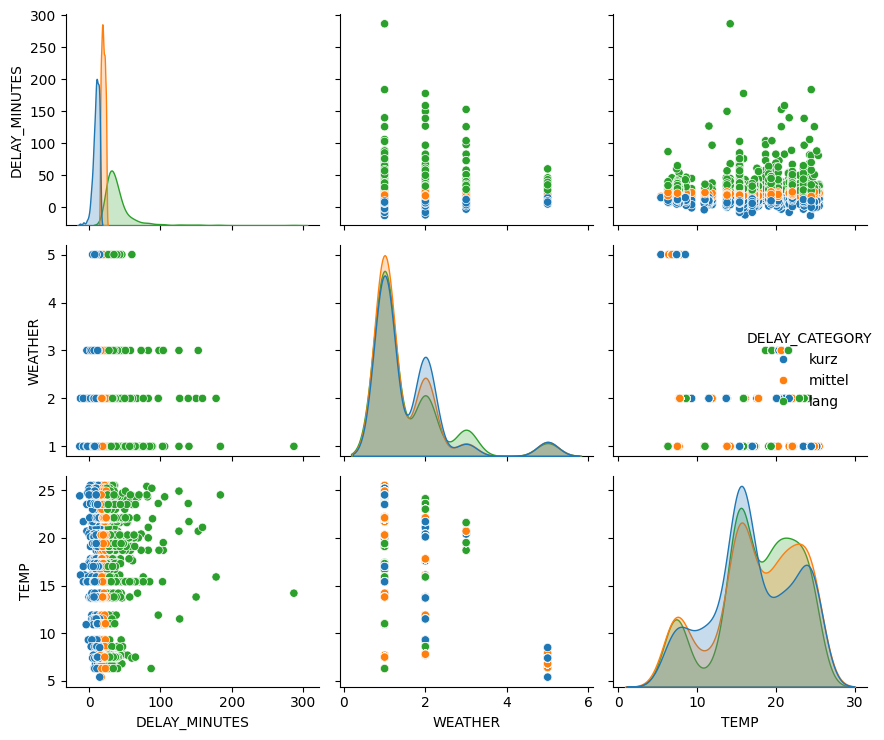

In [78]:
# Relevante Features auswählen
features = ["DELAY_MINUTES", "WEATHER", "TEMP"]
df_selected = zrh_flightdelay[features].copy()

# Optional: Delay in Kategorien einteilen (für farbliche Unterscheidung)
df_selected["DELAY_CATEGORY"] = pd.qcut(df_selected["DELAY_MINUTES"], q=3, labels=["kurz", "mittel", "lang"])

# Pairplot erstellen
sns.pairplot(df_selected, hue="DELAY_CATEGORY")
plt.tight_layout()
plt.show()


## Top 20 most frequent airlines from ZRH

In [79]:
# Anzahl der Flüge pro Airline (Top 20)
top_airline_counts = zrh_flightdelay["AIRLINE"].value_counts().nlargest(20)

# Ausgabe anzeigen
print(top_airline_counts)


AIRLINE
Swiss                592
Helvetic Airways     250
Edelweiss Air        149
Air Baltic           114
easyJet               66
Eurowings             51
British Airways       38
NetJets Europe        34
Chair Airlines        29
KLM                   29
Lufthansa             21
Turkish Airlines      20
Austrian Airlines     19
TAP Air Portugal      17
Iberia                17
Pegasus               16
United Airlines       16
SAS                   15
Aegean Airlines       15
SunExpress            14
Name: count, dtype: int64


## Flight delays for the top airlines

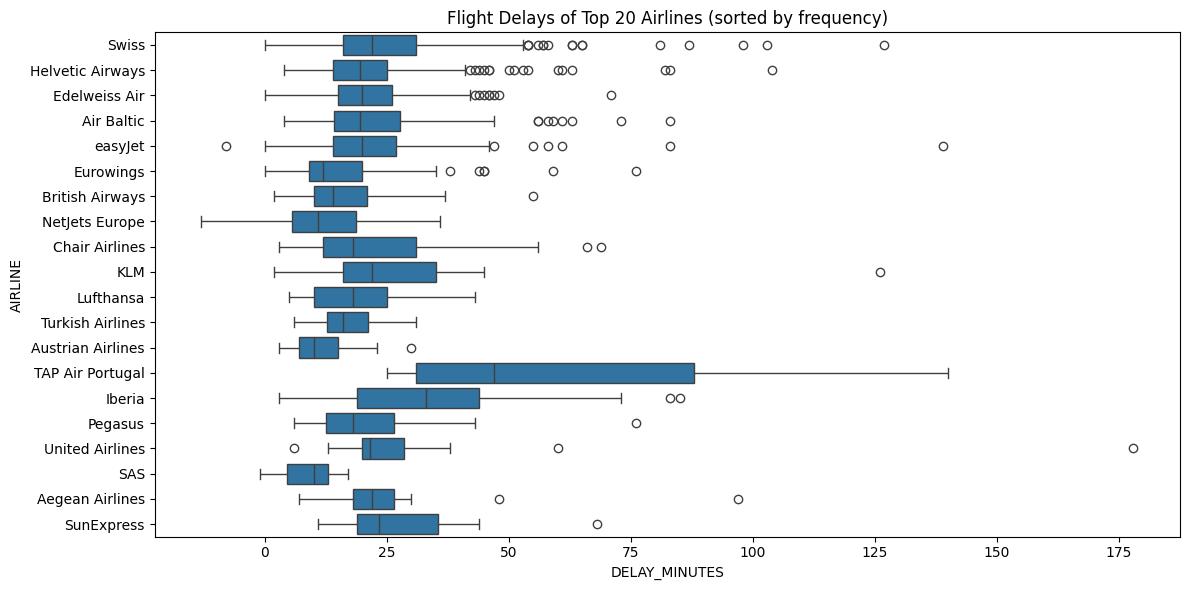

In [80]:
# 1. Die 20 meistvertretenen Airlines finden (inkl. Reihenfolge)
top_airline_counts = zrh_flightdelay["AIRLINE"].value_counts().nlargest(20)
top_airlines = top_airline_counts.index

# 2. DataFrame auf diese Airlines beschränken
df_top = zrh_flightdelay[zrh_flightdelay["AIRLINE"].isin(top_airlines)]

# 3. Boxplot zeichnen mit sortierten Airlines
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top,
    x="DELAY_MINUTES",
    y="AIRLINE",
    order=top_airlines  # Sortiere nach Häufigkeit
)
plt.xticks(rotation=0)
plt.title("Flight Delays of Top 20 Airlines (sorted by frequency)")
plt.tight_layout()
plt.show()


## Top 20 most frequent destinations from ZRH

In [81]:
# Anzahl der Flüge pro Destination (Top 20)
top_destination_counts = zrh_flightdelay["DESTINATION"].value_counts().nlargest(20)

# Ausgabe anzeigen
print(top_destination_counts)


DESTINATION
London               114
Berlin                62
Amsterdam             56
Frankfurt             55
Palma de Mallorca     45
Vienna                42
Hamburg               41
Madrid                39
Paris                 38
Geneva                37
Istanbul              37
Rome                  35
Dusseldorf            34
Barcelona             32
Copenhagen            30
Lisbon                30
Belgrade              29
Munich                29
Athens                28
Milan                 27
Name: count, dtype: int64


## Flight delays for the top destinations

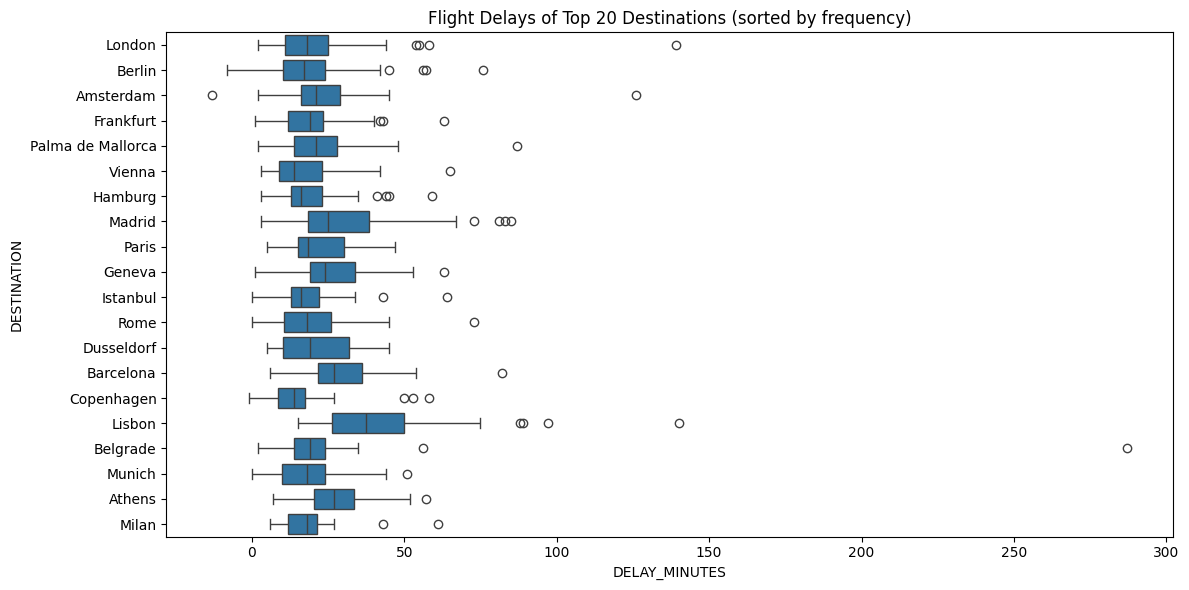

In [82]:
# 1. Die 20 meistvertretenen Destinationen finden (inkl. Reihenfolge nach Häufigkeit)
top_dest_counts = zrh_flightdelay["DESTINATION"].value_counts().nlargest(20)
top_destinations = top_dest_counts.index

# 2. DataFrame auf diese Destinationen beschränken
df_top_dest = zrh_flightdelay[zrh_flightdelay["DESTINATION"].isin(top_destinations)]

# 3. Boxplot zeichnen mit sortierten Kategorien
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top_dest,
    x="DELAY_MINUTES",
    y="DESTINATION",
    order=top_destinations  # Sortierung nach Häufigkeit
)
plt.xticks(rotation=0)
plt.title("Flight Delays of Top 20 Destinations (sorted by frequency)")
plt.tight_layout()
plt.show()


## Create new numeric columns for DESTINATION, AIRLINE, and AIRCRAFT

In [83]:
# Destination in numerische Codes umwandeln
zrh_flightdelay["DEST_CODE"] = zrh_flightdelay["DESTINATION"] \
    .astype("category") \
    .cat.codes

# Airline in numerische Codes umwandeln
zrh_flightdelay["AIRLINE_CODE"] = zrh_flightdelay["AIRLINE"] \
    .astype("category") \
    .cat.codes

# Aircraft in numerische Codes umwandeln
zrh_flightdelay["AIRCRAFT_CODE"] = zrh_flightdelay["AIRCRAFT"] \
    .astype("category") \
    .cat.codes

# Kontrolle
print(zrh_flightdelay[["DESTINATION","DEST_CODE",
                       "AIRLINE","AIRLINE_CODE",
                       "AIRCRAFT","AIRCRAFT_CODE"]].head(50))


          DESTINATION  DEST_CODE           AIRLINE  AIRLINE_CODE AIRCRAFT  \
0             Larnaca         88     Edelweiss Air            34     A320   
1            Pristina        134    Chair Airlines            26     A319   
2               Olbia        121     Edelweiss Air            34     A320   
3           Marrakesh        103     Edelweiss Air            34     A320   
4              Madrid         97  Helvetic Airways            57     E295   
5            Belgrade         16             Swiss            88     BCS3   
6           Frankfurt         61  Helvetic Airways            57     E190   
7              London         92             Swiss            88     BCS1   
8   Palma de Mallorca        125             Swiss            88     A321   
9            Brindisi         29             Swiss            88     A320   
10           Hurghada         74    Chair Airlines            26     A320   
11            Funchal         63     Edelweiss Air            34     A320   

In [84]:
zrh_flightdelay.head(50)

,DESTINATION,IATA_CODE,AIRLINE,AIRCRAFT,DATETIME,DEPART_TIME,DEPART_DATETIME,DELAY_MINUTES,WEATHER,TEMP,DEST_CODE,AIRLINE_CODE,AIRCRAFT_CODE
0,Larnaca,LCA,Edelweiss Air,A320,2025-04-28 05:45:00,06:02,2025-04-28 06:02:00,17,5,5.4,88,34,3
1,Pristina,PRN,Chair Airlines,A319,2025-04-28 05:45:00,06:00,2025-04-28 06:00:00,15,5,5.4,134,26,2
2,Olbia,OLB,Edelweiss Air,A320,2025-04-28 06:25:00,06:45,2025-04-28 06:45:00,20,5,6.4,121,34,3
3,Marrakesh,RAK,Edelweiss Air,A320,2025-04-28 06:25:00,06:35,2025-04-28 06:35:00,10,5,6.4,103,34,3
4,Madrid,MAD,Helvetic Airways,E295,2025-04-28 06:55:00,07:13,2025-04-28 07:13:00,18,5,6.4,97,57,44
5,Belgrade,BEG,Swiss,BCS3,2025-04-28 06:55:00,07:14,2025-04-28 07:14:00,19,5,6.4,16,88,24
6,Frankfurt,FRA,Helvetic Airways,E190,2025-04-28 06:55:00,07:06,2025-04-28 07:06:00,11,5,6.4,61,57,41
7,London,LCY,Swiss,BCS1,2025-04-28 06:55:00,07:34,2025-04-28 07:34:00,39,5,6.4,92,88,23
8,Palma de Mallorca,PMI,Swiss,A321,2025-04-28 06:50:00,07:11,2025-04-28 07:11:00,21,5,6.4,125,88,4
9,Brindisi,BDS,Swiss,A320,2025-04-28 06:50:00,07:17,2025-04-28 07:17:00,27,5,6.4,29,88,3


## Save the DataFrame to a CSV file for training

In [85]:
# Speichern des DataFrames als CSV-Datei
zrh_flightdelay.to_csv("zrh_flightdelay.csv", index=False)